In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import torch
import torch_geometric as pyg

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange

from sklearn.decomposition import PCA

from gnnboundary import *

def seed_all(random_seed):
    #random.seed(random_seed)
    
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
    
    #torch.backends.cudnn.deterministic = True 
    #torch.backends.cudnn.benchmark = False

seed = 3407
seed_all(seed)

In [51]:
def visualize_pca(embeddings: torch.Tensor, labels: torch.Tensor, label_names: list, title: str, hide_classes: list = [], zoom_xlim=None, zoom_ylim=None):
    """
    Visualize graph embeddings using PCA.

    Parameters:
        embeddings (torch.Tensor): Graph embeddings of shape (num_graphs, embedding_dim).
        labels (torch.Tensor): Class labels of shape (num_graphs,).
        label_names (list): List of class names.
        title (str): Title of the plot.
        hide_classes (list): List of classes to hide.
        zoom_xlim (tuple, optional): X-axis limits (min, max).
        zoom_ylim (tuple, optional): Y-axis limits (min, max).

    Returns:
        None
    """
    # Reduce embeddings to 2D
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings.numpy())

    # Plot the 2D embeddings
    plt.figure(figsize=(8, 6))
    
    for label in torch.unique(labels):
        alpha = 0.7 if label not in hide_classes else 0
        idx = labels == label
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=label_names[label], alpha=alpha)
    
    plt.legend()
    plt.title("2D PCA Visualization of Graph Embeddings for " + title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    # Apply zoom if specified
    if zoom_xlim:
        plt.xlim(zoom_xlim)
    if zoom_ylim:
        plt.ylim(zoom_ylim)

    plt.show()


In [ ]:
def visualize_gcn_pca_contour(embeddings, labels, label_names, title="Graph Embeddings", zoom_xlim=None, zoom_ylim=None):
    """
    Visualize PCA embeddings from a trained GCN with a smooth contour plot.

    Parameters:
        embeddings (torch.Tensor): Graph embeddings of shape (num_graphs, embedding_dim).
        labels (torch.Tensor): Class labels of shape (num_graphs,).
        label_names (list): List of class names.

    Returns:
        None
    """
    # Reduce to 2D PCA space
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings.numpy())

    # Separate classes
    cls_1 = embeddings_2d[labels == 0]
    cls_2 = embeddings_2d[labels == 1]
    boundaries = embeddings_2d[labels == 2]

    # Plot PCA embeddings
    plt.figure(figsize=(8, 6))
    sns.kdeplot(x=cls_1[:, 0], y=cls_1[:, 1], levels=10, fill=True, cmap="Blues", alpha=0.5)
    sns.kdeplot(x=cls_2[:, 0], y=cls_2[:, 1], levels=10, fill=True, cmap="Oranges", alpha=0.5)

    plt.scatter(cls_1[:, 0], cls_1[:, 1], color="blue", label=label_names[0], alpha=0.5, s=5)
    plt.scatter(cls_2[:, 0], cls_2[:, 1], color="orange", label=label_names[1], alpha=0.5, s=5)
    plt.scatter(boundaries[:, 0], boundaries[:, 1], color="green", label=label_names[2], edgecolors="black", s=20)

    plt.grid(False)  # Remove grid
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    # Apply zoom if specified
    if zoom_xlim:
        plt.xlim(zoom_xlim)
    if zoom_ylim:
        plt.ylim(zoom_ylim)

    plt.xticks([])  # Hide x-axis labels
    plt.yticks([])  # Hide y-axis labels
    plt.gca().set_frame_on(False)  # Hide the border (axis frame)


    plt.legend()
    plt.title(f"2D PCA of GCN Embeddings: {title}")
    #plt.xlabel("Principal Component 1")
    #plt.ylabel("Principal Component 2")
    plt.show()


# Proteins

In [156]:
proteins = PROTEINSDataset(seed=12345)

model = GCNClassifier(node_features=len(proteins.NODE_CLS),
                            num_classes=len(proteins.GRAPH_CLS),
                            hidden_channels=32,
                            num_layers=3)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
model.load_state_dict(torch.load('ckpts/proteins.pt', map_location=torch.device(device)))
        
dataset_list_gt = proteins.split_by_class()
dataset_list_pred = proteins.split_by_pred(model)

/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.l

In [157]:
dataset_1 = dataset_list_pred[0]
dataset_2 = dataset_list_pred[1]

embeds_1 = dataset_1.model_transform(model, key="embeds_last")
embeds_2 = dataset_2.model_transform(model, key="embeds_last")

In [195]:
import networkx as nx

for data in dataset_1:
    nx.set_node_attributes(data.G, 0, 'label')

for data in dataset_2:
    nx.set_node_attributes(data.G, 1, 'label')

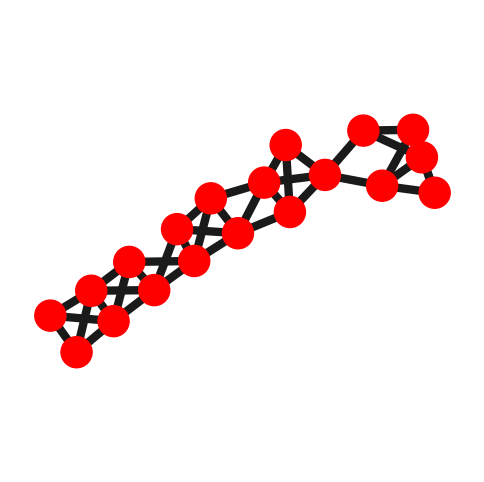

In [203]:
dataset_1.draw(dataset_1[3].G)

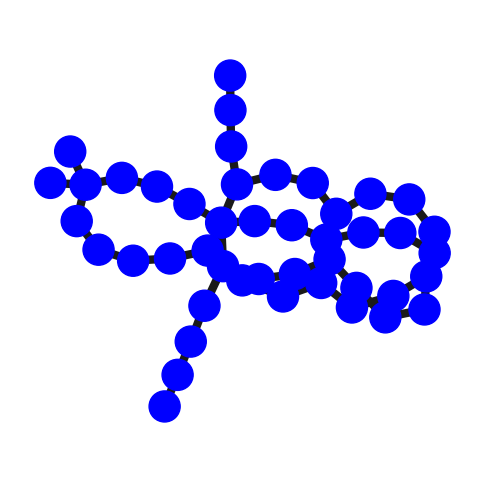

In [204]:
dataset_2.draw(dataset_2[3].G)

In [158]:
labels_1 = torch.tensor(np.repeat(0, len(dataset_1)), device=device)
labels_2 = torch.tensor(np.repeat(1, len(dataset_2)), device=device)

In [159]:
trainer = {(0,1): None}

cls_1, cls_2 = 0, 1

succ_list = []
iteration_list = []

best_trainer = None

In [160]:
embeds = [[] for _ in range(len(proteins.GRAPH_CLS))]
with torch.no_grad():
    for data in tqdm(proteins):
        embeds[data.y.item()].append(model.eval()(pyg.data.Batch.from_data_list([data]))["embeds"].numpy())
mean_embeds = [torch.tensor(np.concatenate(e).mean(axis=0)) for e in embeds]

  0%|          | 0/1113 [00:00<?, ?it/s]

In [161]:
for i in range(5):
    print("Iteration: ", i)
    trainer[(cls_1, cls_2)] = Trainer(
        sampler=(s := GraphSampler(
            max_nodes=25,
            temperature=0.15,
            num_node_cls=len(proteins.NODE_CLS),
            learn_node_feat=True
        )),
        discriminator=model,
        criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(classes=[cls_1, cls_2]), alpha=1, beta=2, weight=25),
            dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
            dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
            dict(key="logits", criterion=MeanPenalty(), weight=0),
            dict(key="omega", criterion=NormPenalty(order=1), weight=1),
            dict(key="omega", criterion=NormPenalty(order=2), weight=1),
            dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
        ]),
        optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
        scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
        dataset=proteins,
        seed = seed, # Added
        classes = (cls_1, cls_2), # Added
        budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    )

    succ, iteration = trainer[(cls_1, cls_2)].train(
        iterations=500,
        target_probs={cls_1: (0.45, 0.55), cls_2: (0.45, 0.55)},
        target_size=30,
        w_budget_init=1,
        w_budget_inc=1.1,
        w_budget_dec=0.95,
        k_samples=32,
    )

    succ_list.append(succ)
        
    if succ:
        iteration_list.append(iteration)
        if best_trainer is None: #In case the last iteration does not succeed, we always return trainer from the first successful iteration
            best_trainer = trainer[(cls_1, cls_2)]
        else:
            trainer[(cls_1, cls_2)] = best_trainer

succ_list = np.array(succ_list)
iteration_list = np.array(iteration_list)

if iteration_list.size > 0:
    iteration_list = np.mean(iteration_list)
else:
    iteration_list = "No Success"


Iteration:  0


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped: [0.48656079173088074, 0.5134392380714417]
Iteration:  1


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped: [0.5323245525360107, 0.46767547726631165]
Iteration:  2


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped: [0.4995148777961731, 0.5004851222038269]
Iteration:  3


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped: [0.5198879241943359, 0.48011213541030884]
Iteration:  4


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped: [0.5310173034667969, 0.4689826965332031]


In [162]:
trainer = trainer[(0, 1)] if best_trainer is None else best_trainer

In [163]:
num_boundary_samples = 500

In [164]:
sample_fn = lambda: trainer.evaluate(bernoulli=True)

boundary_graph_embeddings = []
probs = []
final_embeddings = torch.empty((0, trainer.predict(sample_fn()[0])['embeds_last'].shape[1]))

print(f"Sampling {num_boundary_samples} Boundary Graphs")
for i in range(num_boundary_samples):
    probs.append(trainer.predict(sample_fn()[0])["probs"][0].numpy().astype(float))
    boundary_graph_embeddings.append(trainer.predict(sample_fn()[0])['embeds'])
    final_embed = trainer.predict(sample_fn()[0])['embeds_last']
    final_embeddings = torch.vstack([final_embeddings, final_embed])
        

Sampling 500 Boundary Graphs


pred={'logits': tensor([[0.0818, 0.0980]]), 'probs': tensor([[0.4960, 0.5040]]), 'embeds': tensor([[-7.2450e-01, -4.0468e-01,  3.2456e+00,  4.2347e-02, -1.2593e-01,
         -7.3840e-01, -1.4744e-01, -2.4254e-01,  2.6354e-01, -1.7302e-02,
         -4.8472e-01,  9.1764e-01, -4.5745e-01, -4.4220e+00, -5.1623e+00,
         -2.5514e-01, -4.1372e-02, -1.8960e+00,  5.9091e-01, -2.1512e-01,
          1.0940e+00, -1.6694e+00, -1.4046e-01,  6.5566e-01,  5.8319e-01,
         -1.0166e-01, -6.7151e-01,  4.6802e-01,  3.0210e+00, -4.6088e-01,
         -1.3474e+00,  1.1189e+00, -4.5281e-02, -2.5292e-02,  2.0285e-01,
          2.6467e-03, -7.8708e-03, -4.6150e-02, -9.2151e-03, -1.5159e-02,
          1.6471e-02, -1.0814e-03, -3.0295e-02,  5.7352e-02, -2.8591e-02,
         -2.7637e-01, -3.2265e-01, -1.5946e-02, -2.5858e-03, -1.1850e-01,
          3.6932e-02, -1.3445e-02,  6.8372e-02, -1.0434e-01, -8.7790e-03,
          4.0979e-02,  3.6450e-02, -6.3539e-03, -4.1969e-02,  2.9251e-02,
          1.8881e-01,

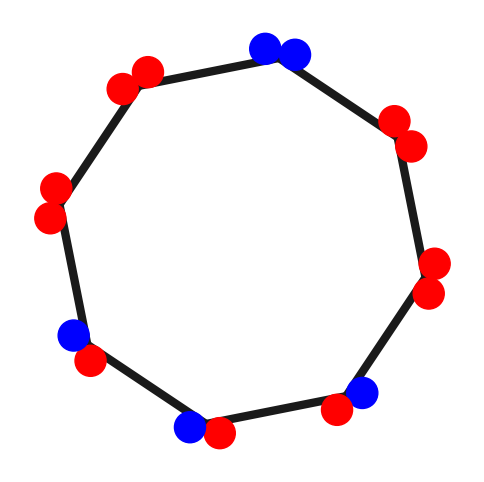

(<networkx.classes.graph.Graph at 0x1797f4160>,
 [0.49595528841018677, 0.504044771194458])

In [173]:
trainer.evaluate(show=True)

In [165]:
labels_3 = torch.tensor(np.repeat(2, num_boundary_samples), device=device)
all_embeds = torch.cat([embeds_1, embeds_2, final_embeddings], dim=0)
all_labels = torch.cat([labels_1, labels_2, labels_3], dim=0)
label_names = ["No-Enzyme", "Enzyme", "Boundary Graph"]

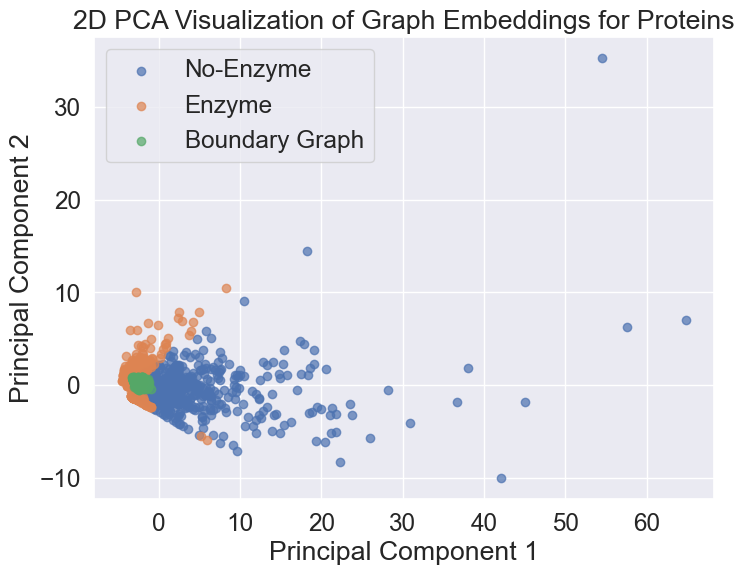

In [166]:
visualize_pca(all_embeds, all_labels, label_names, title="Proteins")

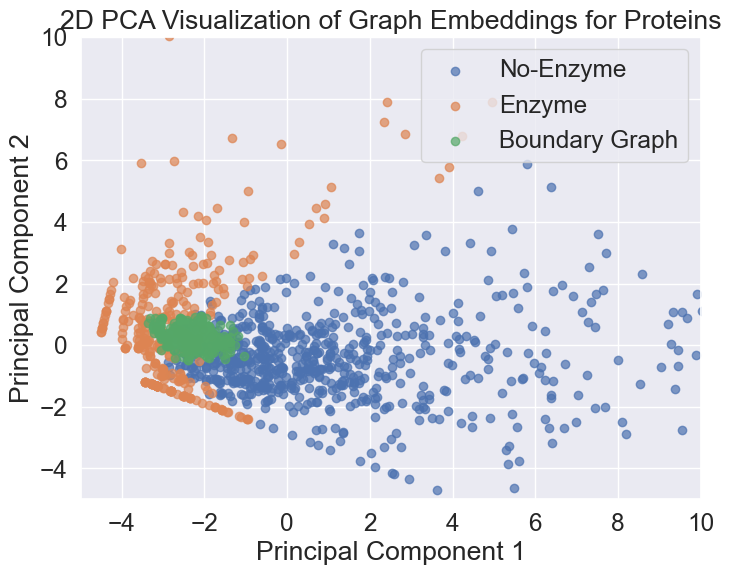

In [167]:
visualize_pca(all_embeds, all_labels, label_names, title="Proteins", zoom_xlim=(-5, 10), zoom_ylim=(-5, 10))


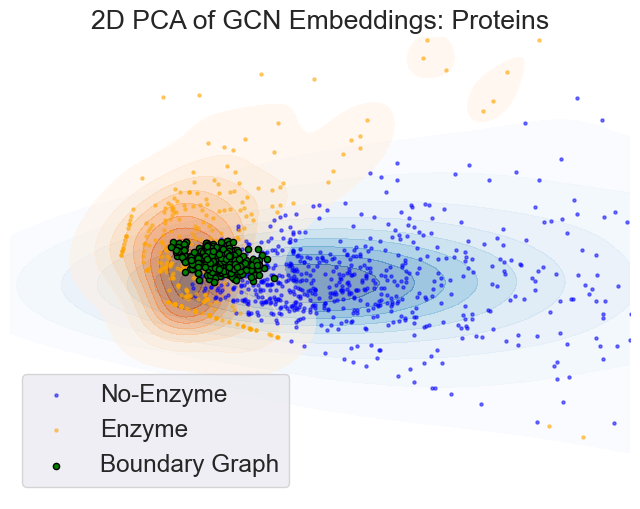

In [168]:
visualize_gcn_pca_contour(all_embeds, all_labels, label_names=["No-Enzyme", "Enzyme", "Boundary Graph"], title="Proteins", zoom_xlim=(-7, 7), zoom_ylim=(-8, 8))